In [50]:
from omegaconf import OmegaConf
import torch
import matplotlib.pyplot as plt
from torch_geometric.data import Batch
import numpy as np
import pandas as pd
from datasets import load_datamodule

from models.vae import VanillaVAE
from models.vae import BaseModel as BaseVAE

from models.encoder_archive import BaseModel as EctEncoder

from metrics.metrics import get_mse_metrics
from metrics.accuracies import compute_mse_accuracies
from metrics.loss import compute_mse_loss_fn

from layers.ect import EctLayer, EctConfig
from layers.directions import generate_directions

DEVICE = "cuda:0"
ECT_PLOT_CONFIG = {"cmap":"bone","vmin":-0.5,"vmax":1.5}
PC_PLOT_CONFIG = {"s":2.5,"c":'.5'}

encoder_config = OmegaConf.load("./configs/config_encoder_mnist_rotated.yaml")
# vae_config = OmegaConf.load("./configs/config_vae_mnist.yaml")

In [51]:
layer = EctLayer(
    EctConfig(
        num_thetas=encoder_config.layer.ect_size,
        bump_steps=encoder_config.layer.ect_size,
        normalized=True,
        device=DEVICE,
    ),
    v=generate_directions(encoder_config.layer.ect_size,encoder_config.layer.dim, DEVICE),
)

dm = load_datamodule(encoder_config.data)



# Load the encoder 
ect_encoder_litmodel = EctEncoder.load_from_checkpoint(
    f"./trained_models/{encoder_config.model.save_name}",
    layer=layer,
    ect_size=encoder_config.layer.ect_size,
    hidden_size=encoder_config.model.hidden_size,
    num_pts=encoder_config.model.num_pts,
    num_dims=encoder_config.model.num_dims,
    learning_rate=encoder_config.model.learning_rate,
).to(DEVICE)

C:\Users\ernst\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\lightning\pytorch\utilities\migration\utils.py:56: The loaded checkpoint was produced with Lightning v2.3.3, which is newer than your current Lightning version: v2.2.3


In [52]:

y = dm.test_ds[:].y

print(torch.unique(y))

idxs = torch.hstack(
    [
        # torch.where(y==1)[0][:1],
        # torch.where(y==2)[0][:1],
        torch.where(y==4)[0][:1],
    ]
)


data_list = []
for idx in idxs:
    data_list.append(dm.test_ds[idx])


batch = Batch.from_data_list(data_list).to(DEVICE)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


In [53]:
batch.to(DEVICE)
ect = layer(batch,batch.batch).unsqueeze(1)

print(ect.shape)

ect_batch = []

for idx in range(ect.shape[3]):
    ect_batch.append(torch.roll(ect,idx,3))


ect_batch = torch.stack(ect_batch)


torch.Size([1, 1, 64, 64])


In [54]:
batch.x


tensor([[-0.4783, -0.5802],
        [ 0.8165,  0.3446],
        [-0.7558, -0.3952],
        [ 0.2616,  0.0672],
        [-0.3858,  0.4371],
        [ 0.1691, -0.6727],
        [ 0.9089,  0.1597],
        [-0.5708, -0.3952],
        [-0.3858,  0.4371],
        [ 0.1691, -0.0253],
        [ 0.3540,  0.3446],
        [ 0.0766, -0.6727],
        [-0.0159,  0.2522],
        [-0.6633,  0.4371],
        [ 0.3540,  0.2522],
        [-0.2933, -0.4877],
        [ 0.1691,  0.3446],
        [-0.3858,  0.3446],
        [ 0.4465,  0.4371],
        [ 0.2616, -0.0253],
        [-0.7558, -0.3952],
        [-0.6633, -0.3952],
        [-0.0159,  0.4371],
        [-0.0159,  0.4371],
        [-0.6633,  0.6221],
        [-0.2009, -0.6727],
        [-0.2009, -0.5802],
        [ 0.0766, -0.6727],
        [ 0.2616, -0.3952],
        [ 0.1691, -0.6727],
        [ 0.7240,  0.2522],
        [ 0.8165,  0.3446],
        [ 0.0766,  0.3446],
        [ 0.1691,  0.0672],
        [-0.8482, -0.3027],
        [ 0.8165,  0

In [55]:
def rotate(p, origin=(0, 0), degrees=0):
    angle = np.deg2rad(degrees)
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle),  np.cos(angle)]])
    o = np.atleast_2d(origin)
    p = np.atleast_2d(p)
    return np.squeeze((R @ (p.T-o.T) + o.T).T)



angles = torch.linspace(360, 0, ect.shape[3])
ls = []
x = batch.x.cpu().numpy().reshape(-1,2)
for angle in angles: 
    ls.append(rotate(x, degrees=angle).reshape(1,128,2))

rotated_point_clouds = np.vstack(ls)


with torch.no_grad():
    recon_batch = ect_encoder_litmodel.model.forward(ect_batch.movedim(-1,-2))


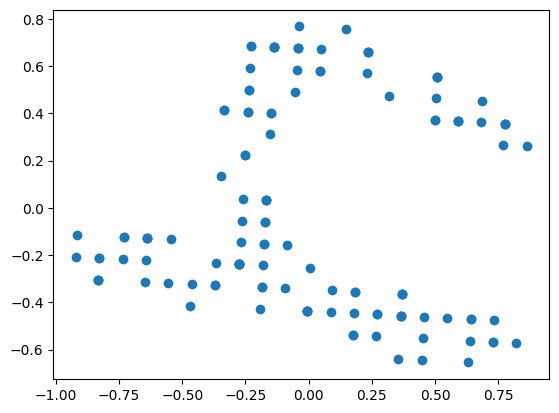

In [56]:
# pts = rotate(x,degrees=180)
plt.scatter(rotated_point_clouds[32,:,0],rotated_point_clouds[32,:,1])

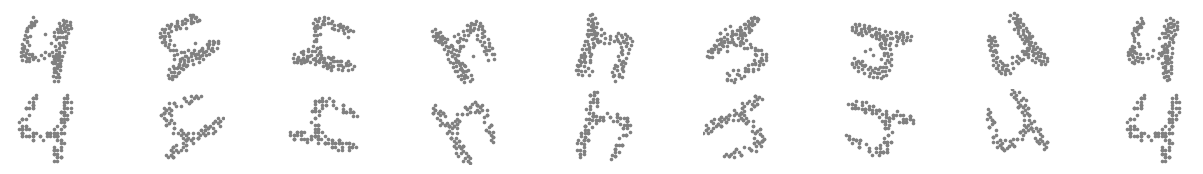

In [57]:
fig, axes = plt.subplots(
    nrows=2, ncols=9, figsize=(16,2)
)
fig.subplots_adjust(wspace=0.05,hspace=0.05)

for idx in range(8):
    pts = recon_batch[8*idx].view(-1,2).cpu().detach().squeeze().numpy()
    pts = rotate(pts, degrees=-90)
    
    axes[0,idx].scatter(pts[:,0],pts[:,1],**PC_PLOT_CONFIG)
    axes[0,idx].set_xlim([-1,1])
    axes[0,idx].set_ylim([-1,1])
    axes[0,idx].set_aspect(1)
    axes[0,idx].axis("off")

    pts = rotated_point_clouds[8*idx].reshape(-1,2)
    pts = rotate(pts, degrees=-90)
    axes[1,idx].scatter(pts[:,0],pts[:,1],**PC_PLOT_CONFIG)
    axes[1,idx].set_xlim([-1,1])
    axes[1,idx].set_ylim([-1,1])
    axes[1,idx].set_aspect(1)
    axes[1,idx].axis("off")

idx = -1
# print(recon_pts_x.shape)
pts = recon_batch[idx].view(-1,2).cpu().detach().squeeze().numpy()
pts = rotate(pts, degrees=-90)

axes[0,idx].scatter(pts[:,0],pts[:,1],**PC_PLOT_CONFIG)
axes[0,idx].set_xlim([-1,1])
axes[0,idx].set_ylim([-1,1])
axes[0,idx].set_aspect(1)
axes[0,idx].axis("off")

# print(recon_pts_x.shape)
pts = rotated_point_clouds[idx].reshape(-1,2)
pts = rotate(pts, degrees=-90)

axes[1,idx].scatter(pts[:,0],pts[:,1],**PC_PLOT_CONFIG)
axes[1,idx].set_xlim([-1,1])
axes[1,idx].set_ylim([-1,1])
axes[1,idx].set_aspect(1)
axes[1,idx].axis("off")
    
plt.savefig("./figures/img/mnist/rotated_pointcloud_reconstructed.png",bbox_inches='tight', pad_inches=0,transparent=True,dpi=500)

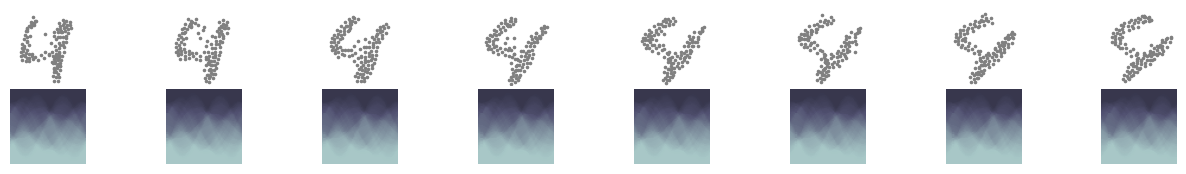

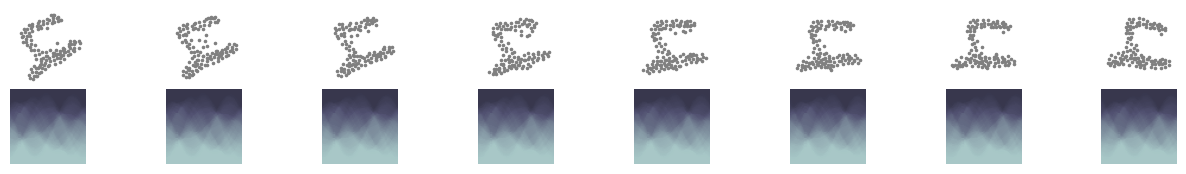

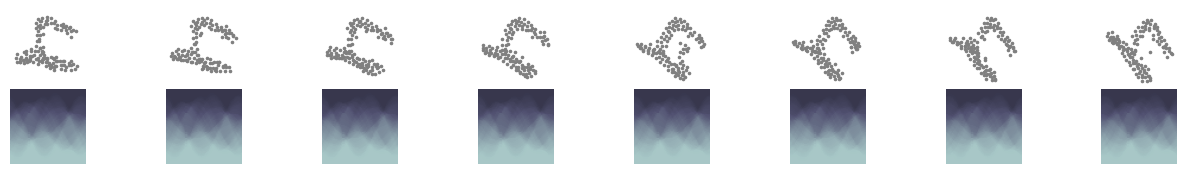

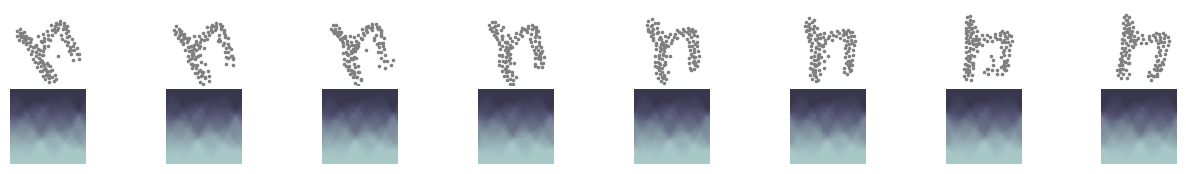

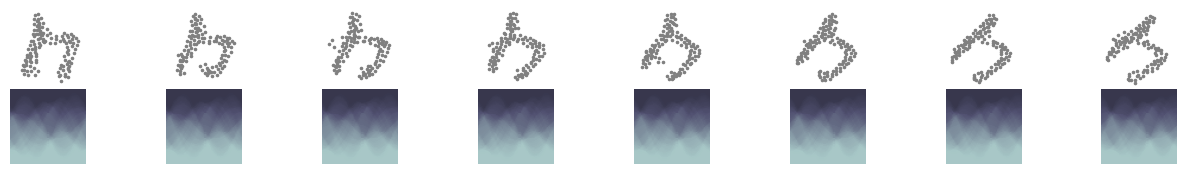

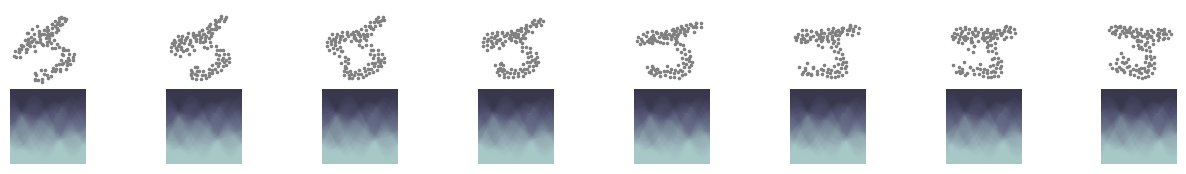

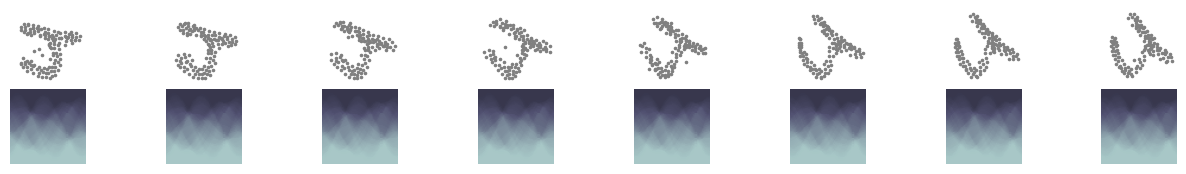

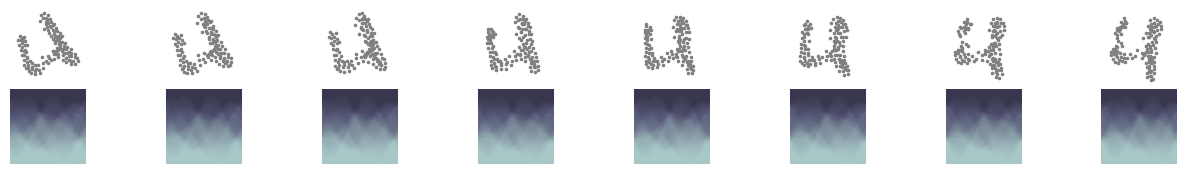

In [58]:

for batch_idx in range(8):
    fig, axes = plt.subplots(
        nrows=2, ncols=8, figsize=(16,2)
    )
    fig.subplots_adjust(wspace=0.05,hspace=0.05)

    for idx, ax in enumerate(axes.T):
        
        # print(recon_pts_x.shape)
        recon_pts = recon_batch[8*batch_idx + idx].view(-1,2).cpu().detach().squeeze().numpy()
        
        recon_pts = rotate(recon_pts, degrees=-90)
        
        ax[0].scatter(recon_pts[:,0],recon_pts[:,1],**PC_PLOT_CONFIG)
        ax[0].set_xlim([-1,1])
        ax[0].set_ylim([-1,1])
        ax[0].set_aspect(1)
        ax[0].axis("off")

        ax[1].imshow(ect_batch[8*batch_idx + idx].cpu().detach().squeeze().numpy(),**ECT_PLOT_CONFIG)
        ax[1].axis("off")
    
# plt.savefig("./figures/img/dsprites/reconstructed_pointcloud.svg",transparent=True)

# Generate Loss term

In [59]:
# def update_loss_dict(data, losses):
#     label = data.y
#     angles = torch.linspace(0, 2 * torch.pi, 64)
#     point_clouds = torch.stack(
#         [rotate(data.x, angle).view(128, 2) for angle in angles]
#     ).cuda()
#     batch = Batch.from_data_list([Data(x=pc.view(-1, 2)) for pc in point_clouds])
#     with torch.no_grad():
#         rotated_ect = model.layer(batch, batch.batch).unsqueeze(1)
#         recon_pc = model.model.forward(rotated_ect)
#     ch = distChamfer(point_clouds, recon_pc.view(-1, 128, 2))
#     return [
#         torch.stack([torch.tensor(angle), label[0], ch.cpu()[angle]])
#         for angle in range(64)
#     ]

# Borrow from https://github.com/ThibaultGROUEIX/AtlasNet
def distChamfer(a, b):
    x, y = a, b
    bs, num_points, points_dim = x.size()
    xx = torch.bmm(x, x.transpose(2, 1))
    yy = torch.bmm(y, y.transpose(2, 1))
    zz = torch.bmm(x, y.transpose(2, 1))
    diag_ind = torch.arange(0, num_points).to(a).long()
    rx = xx[:, diag_ind, diag_ind].unsqueeze(1).expand_as(xx)
    ry = yy[:, diag_ind, diag_ind].unsqueeze(1).expand_as(yy)
    P = rx.transpose(2, 1) + ry - 2 * zz
    return P.min(1)[0].mean(axis=1) + P.min(2)[0].mean(axis=1)


losses_rot = []
for data in dm.test_ds:
    angle = np.random.randint(0,64) * 360 / 64
    rot_pcs = rotate(data.x,degrees=angle)
    l = distChamfer(torch.tensor(rot_pcs,dtype=torch.float).view(1,128,2),data.x.view(1,128,2)) 
    losses_rot.append({"loss":l,"model":"RandomRotation","class":data.y.item()})

# Table for loss term. 

In [60]:
rotation_loss = torch.load("./results/rotation.pt").cpu().numpy()

In [65]:
losses = [{"theta":r[0],"class":r[1], "model":"ECT-MLP", "loss": r[2]} for r in rotation_loss] + losses_rot


In [71]:
df = pd.DataFrame(losses)
df["loss"] = df["loss"] * 1e4
df[["model","loss"]].groupby(["model"]).agg(["mean","std"]).T

model        ECT-MLP RandomRotation
loss mean  53.649736      635.34155
     std   14.985865     701.581906